# Random Forest Weighted Entropy
As metnioned in the previous notebook, there are different methods to handle missing values in a random forest. A problem with a lot of them is that a lot of them train on the missing data in the train set, to classify the missing data in the test set better. However, what I want to achieve is a better classification on a test set without missing data, so most of those algorithms won't work for this.

During one of the thesis meeting sessions, we brainstormed which possible approach would be best. Our guess was weighted branches. However, usually this trains weights during training, and during testing, it discovers all possible branches, and creates a weighted sum of all those probabilities. This is of course not useful if there isn't any missing data in the test set.

So we need to find a way to use this during training. I'll attempt this using a weighted entropy.

This is the current calculate_entropy function (located in  CustomForest/decision_tree.py):

In [3]:
import math
import numpy as np
import pandas as pd


def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        print(f"p({label}) = {p}")
        entropy += -p * log2(p)
    return entropy

So for each unique label in our tree node, we calculate the relative frequncy of that label in the node (p) and multiply it with the log2 of that frequency (which is negative, since probabilities are between 0 and 1), but it's made positive again using the minus sign. We then sum all those values together, and return the entropy.

Let's give an example:

In [4]:
y = np.array([1, 1, 1, 0])
calculate_entropy(y)

p(0) = 0.25
p(1) = 0.75


0.8112781244591328

Instead of those labels, we now also have a weight for each of the instances and calculate the weighted entropy. All those weights start with 1, but get halved when a split has occured of which the value for the corresponding data instance is missing.

If the data is random, p is lower. `p = count / len(y)`. We want to decrease the penalty (so increas p) if there are lower weihgts and increase the penality if there are higher weights. WARNING: All without mising data should be better than with missing data in the pure values.

We also want lower values to have less impact on the count.

Some notes when searching for a new entropy function:
![](img/entropy_notes.png)

In [5]:
weights = np.ones(len(y))

weights[0] = 0.5

np.concatenate((y.reshape(-1, 1), weights.reshape(-1, 1)), axis=1)

array([[1. , 0.5],
       [1. , 1. ],
       [1. , 1. ],
       [0. , 1. ]])

In [6]:
def calculate_weighted_entropy_diff(y, weights):
    """ Calculate the weighted entropy of label array y """
    # Counts diff from normal frequency in most occuring class
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    weighted_sum = np.sum(weights)
    most_common_label = unique_labels[np.argmax([len(y[y == label]) for label in unique_labels])]
    entropy = 0
    entropy_text_formula = ""
    for label in unique_labels:
        label_weights = weights[y == label]

        label_count = len(label_weights)

        p = label_count / len(y)

        if label == most_common_label:
            weighted_count = sum(label_weights)
            p_weighted = weighted_count / weighted_sum
            diff = p_weighted - p
            print(f"Diff: {diff}")
            print(f"Using weighted p ({p_weighted}) instead of p ({p})")
            p = p_weighted

        label_weight = np.prod(label_weights)
        entropy += -p * log2(p)
        entropy_text_formula += f"-{p} * log2({p}) (for label {label}) + "
    print(entropy_text_formula)
    return entropy

In [7]:
def calculate_weighted_entropy(y, weights):
    """ Calculate the weighted entropy of label array y """
    # Counts diff from normal frequency in most occuring class
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    normalized_weights = weights / np.sum(weights)
    entropy = 0
    for label in unique_labels:
        p = np.sum(normalized_weights[y == label])
        entropy += -p * log2(p)
    return entropy

Let's verify our entropy is the same if all weights are 1, our entropy is lower if the weights of the ones are lowered and higher if the weights of the zeros are lowered (a higher entropy means more random, less grouped).

In [8]:
# ones lowered, should be higher
weights = np.array([0.5, 1, 1, 1])
calculate_weighted_entropy(y, weights)

0.863120568566631

In [9]:
# weights all 1, should be the same
weights = np.array([1, 1, 1, 1])
calculate_weighted_entropy(y, weights)

0.8112781244591328

In [10]:
# zeros lowered, should be lower
weights = np.array([1, 1, 1, 0.5])
calculate_weighted_entropy(y, weights)

0.5916727785823275

This seems to work as intended. Let's try another example:

In [11]:
labels = np.array([1, 1, 1, 0, 0, 0, 0, 0])

In [12]:
weights = np.array([1, 1, 1, 1, 1, 1, 1, 1])
calculate_weighted_entropy(labels, weights)

0.9544340029249649

In [13]:
weights = np.array([1, 1, 1, 1, 1, 1, 1, 0.5])
calculate_weighted_entropy(labels, weights)

0.9709505944546686

In [14]:
weights = np.array([1, 1, 1, 1, 1, 1, 1, 0.25])
calculate_weighted_entropy(labels, weights)

0.9784493292686189

In [15]:
weights = np.array([0.5, 1, 1, 1, 1, 1, 1, 1])
calculate_weighted_entropy(labels, weights)

0.9182958340544896

Now we have a new entropy function, we need to implement the weights. In the build_tree function, they should get initialized with 1 (unless it's a subtree, then the value should be passed on). If the split occurs on a missing value, the weights should be halved.

Because the split always happen on the entropy and the test set doesn't contain missing values, we won't change the evaluation function.

In [4]:
from util import evaluate_no_cv
from CustomForest import WeightedClassificationTree
import numpy as np

tree = WeightedClassificationTree()

y = np.array([1, 1, 1, 0])
X = np.array([[1, 1], [1, 2], [1, 3], [2, 1]])

tree.fit(X, y)
# tree.print_tree()
print(tree.predict(X))
print(tree.predict([[2, 1], [1, 1], [1, 3], [2, 1]]))

best_criteria: {'feature_i': 0, 'threshold': 1}
[1.0, 1.0, 1.0, 0.0]
[1.0, 1.0, 1.0, 1.0]


C:\Users\arnod\PycharmProjects\thesis\CustomForest\utils.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


In [5]:
from CustomForest import ClassificationTree

tree = ClassificationTree()
tree.fit(X, y)
print(tree.predict(X))
print(tree.predict([[2, 1], [1, 1], [1, 3], [2, 1]]))

[1, 1, 1, 0]
[1, 1, 1, 1]


In [3]:
from util import evaluate_no_cv
from CustomForest import WeightedClassificationTree
import numpy as np

tree = WeightedClassificationTree()

y = np.array([1, 1, 1, 0])
X = np.array([[1, np.nan], [np.nan, 2], [np.nan, 3], [2, 1]])

tree.fit(X, y)
tree.predict([[2, 1], [1, 1], [1, 3], [2, 1]])

best_criteria: {'feature_i': 0, 'threshold': 2.0}
best_criteria: {'feature_i': 1, 'threshold': 2.0}
best_criteria: {'feature_i': 0, 'threshold': 2.0}


[0.0, 1.0, 1.0, 0.0]

In [4]:
tree.print_tree()

1:2.0? 
 T->1.0
 F->0:2.0? 
  T->0.0
  F->1.0


In [1]:
# try a larger sample, so we can test a weighted random forest
from util import evaluate_no_cv
from CustomForest import WeightedClassificationTree, RandomForest
import numpy as np

clf = RandomForest(weighted=True)

y = np.array([1, 1, 1, 0])
X = np.array([[1, np.nan], [np.nan, 2], [np.nan, 3], [2, 1]])

clf.fit(X, y)
clf.predict([[2, 1], [1, 1], [1, 3], [2, 1]])

C:\Users\arnod\PycharmProjects\thesis\CustomForest\weighted_decision_tree.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])
Training: 100% [------------------------------------------------] Time: 0:00:00


array([1, 1, 1, 1], dtype=int64)

# Real data
up to now, I've worked with small test samples, let's try on the actual dataset

In [1]:
from util import get_train_dataset, get_features, fix_test
from sklearn.model_selection import train_test_split

df = get_train_dataset().sample(200)
# df = df.dropna()
train, test = train_test_split(df, test_size=0.2, random_state=42)
test = test.dropna()

train_x = get_features(train)
test_x = get_features(test, test=True)
test_x = fix_test(test_x, train_x.columns)

train_y = train['reaction']
test_y = test['reaction']

In [2]:
from util import evaluate_no_cv
from CustomForest import RandomForest

rf = RandomForest()
evaluate_no_cv(rf, train_x, train_y, test_x, test_y)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\arnod\PycharmProjects\thesis\CustomForest\utils.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])
100%|██████████| 100/100 [00:15<00:00,  6.65it/s]

ROC AUC: 1.000


1.0

In [4]:
rf = RandomForest(weighted=True)
evaluate_no_cv(rf, train_x, train_y, test_x, test_y)

C:\Users\arnod\PycharmProjects\thesis\CustomForest\weighted_decision_tree.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([X_1, X_2])


ROC AUC: 1.000


1.0

In [1]:
from CustomForest import RandomForest
import numpy as np
from util import get_train_dataset, get_features, fix_test, evaluate_no_cv
from sklearn.model_selection import train_test_split
import pandas as pd


def get_train_test(df, seed, drop_train_na=False):
    train, test = train_test_split(df, test_size=0.2, random_state=seed)

    test.dropna(inplace=True)
    if drop_train_na:
        train.dropna(inplace=True)

    x = get_features(train)
    y = train['reaction']

    x_test = get_features(test, test=True)
    x_test = fix_test(x_test, x.columns)
    y_test = test['reaction']

    return x, y, x_test, y_test

In [ ]:
models_to_evaluate = [
    {'name': 'RandomForest', 'model': RandomForest()},
    {'name': 'WeightedRandomForest', 'model': RandomForest(weighted=True)},
    {'name': 'RandomForest (no train nan)', 'model': RandomForest(), 'drop_train_na': True},
    {'name': 'WeightedRandomForest (no train nan)', 'model': RandomForest(weighted=True), 'drop_train_na': True},
]

df = get_train_dataset()  #.sample(100)

folds = 5
scores = pd.DataFrame()
for i, model in enumerate(models_to_evaluate):
    print(f"Running {model['name']} ({i + 1}/{len(models_to_evaluate)})")
    for seed in range(folds):

        drop_train_na = model.get('drop_train_na', False)

        x, y, x_test, y_test = get_train_test(df, seed, drop_train_na=drop_train_na)

        if 'imputer' in model:
            x = model['imputer'].fit_transform(x)

        auc = evaluate_no_cv(model['model'], x, y, x_test, y_test)
        scores = scores.append({
            'model': model['name'],
            'auc': auc,
        }, ignore_index=True)

scores

Running RandomForest (1/4)


100%|██████████| 100/100 [28:21<00:00, 17.02s/it]


ROC AUC: 0.936


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [32:32<00:00, 19.52s/it] 


ROC AUC: 0.913


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [34:26<00:00, 20.66s/it]


ROC AUC: 0.925


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [32:15<00:00, 19.35s/it]


ROC AUC: 0.917


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [32:53<00:00, 19.74s/it]


ROC AUC: 0.930
Running WeightedRandomForest (2/4)


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [2:09:26<00:00, 77.67s/it]  


ROC AUC: 0.939


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [2:01:21<00:00, 72.82s/it]  


ROC AUC: 0.910


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [3:07:03<00:00, 112.23s/it] 


ROC AUC: 0.933


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [27:46<00:00, 16.67s/it]t]   


ROC AUC: 0.932


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [27:32<00:00, 16.52s/it]


ROC AUC: 0.918


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({
100%|██████████| 100/100 [27:57<00:00, 16.78s/it]


ROC AUC: 0.933


C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/757821529.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


,model,auc
0,RandomForest,0.936162
1,RandomForest,0.913070
2,RandomForest,0.925187
3,RandomForest,0.917499
4,RandomForest,0.930375
5,WeightedRandomForest,0.938669
6,WeightedRandomForest,0.910432
7,WeightedRandomForest,0.933117
8,WeightedRandomForest,0.923381
9,WeightedRandomForest,0.927235


In [4]:
baseline = scores[(scores['model'] == 'RandomForest')]['auc'].mean()
scores["improvement"] = scores["auc"] - baseline
scores

,model,auc,improvement
0,RandomForest,0.936162,0.011703
1,RandomForest,0.913070,-0.011389
2,RandomForest,0.925187,0.000729
3,RandomForest,0.917499,-0.006959
4,RandomForest,0.930375,0.005917
5,WeightedRandomForest,0.938669,0.014210
6,WeightedRandomForest,0.910432,-0.014026
7,WeightedRandomForest,0.933117,0.008659
8,WeightedRandomForest,0.923381,-0.001078
9,WeightedRandomForest,0.927235,0.002776


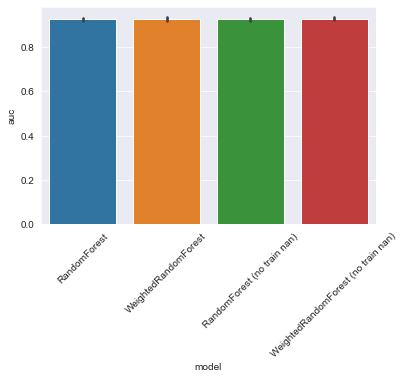

In [5]:
import seaborn as sns

plot = sns.barplot(x="model", y="auc", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
pass

C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/936369140.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


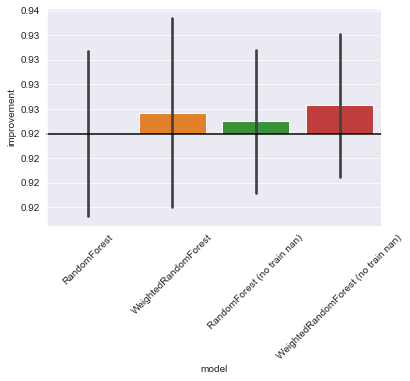

In [6]:
plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd")

plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])
pass

In [8]:
# let's compare with sklearn random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

models_to_evaluate = [
    {'name': 'RandomForest (sklearn)', 'model': RandomForestClassifier(), 'imputer': SimpleImputer()},
    {'name': 'RandomForest (sklearn) (no train nan)', 'model': RandomForestClassifier(), 'drop_train_na': True,
     'imputer': SimpleImputer()},
]

df = get_train_dataset()  #.sample(100)

folds = 5
for i, model in enumerate(models_to_evaluate):
    print(f"Running {model['name']} ({i + 1}/{len(models_to_evaluate)})")
    for seed in range(folds):

        drop_train_na = model.get('drop_train_na', False)

        x, y, x_test, y_test = get_train_test(df, seed, drop_train_na=drop_train_na)

        if 'imputer' in model:
            x = model['imputer'].fit_transform(x)

        auc = evaluate_no_cv(model['model'], x, y, x_test, y_test)
        scores = scores.append({
            'model': model['name'],
            'auc': auc,
        }, ignore_index=True)

Running RandomForest (sklearn) (1/2)


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.946


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.933


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.940


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.941


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.939
Running RandomForest (sklearn) (no train nan) (2/2)


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.938


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.926


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.945


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


ROC AUC: 0.930
ROC AUC: 0.940


C:\Users\arnod\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/840427728.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({


,model,auc,improvement
0,RandomForest,0.936162,0.011703
1,RandomForest,0.913070,-0.011389
2,RandomForest,0.925187,0.000729
3,RandomForest,0.917499,-0.006959
4,RandomForest,0.930375,0.005917
5,WeightedRandomForest,0.938669,0.014210
6,WeightedRandomForest,0.910432,-0.014026
7,WeightedRandomForest,0.933117,0.008659
8,WeightedRandomForest,0.923381,-0.001078
9,WeightedRandomForest,0.927235,0.002776


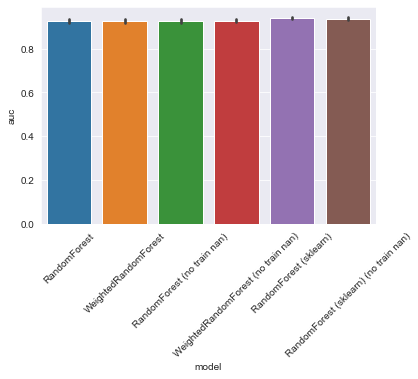

In [10]:
import seaborn as sns

baseline = scores[(scores['model'] == 'RandomForest')]['auc'].mean()
scores["improvement"] = scores["auc"] - baseline

plot = sns.barplot(x="model", y="auc", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

scores

C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/1258050587.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


[Text(0, -0.01, '0.91'),
 Text(0, -0.005, '0.92'),
 Text(0, 0.0, '0.92'),
 Text(0, 0.004999999999999999, '0.93'),
 Text(0, 0.01, '0.93'),
 Text(0, 0.015000000000000001, '0.94'),
 Text(0, 0.019999999999999997, '0.94'),
 Text(0, 0.025, '0.95')]

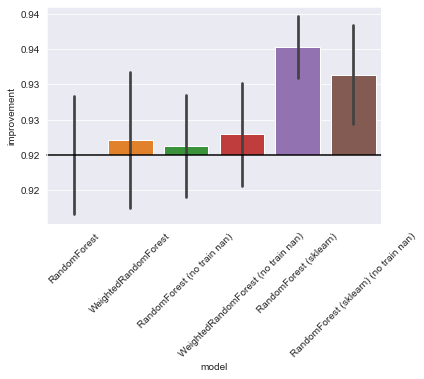

In [11]:
plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])

Let's try sklearn random forest, but give all samples containing nan a weight of 0.5.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


class RandomForestWithWeights(RandomForestClassifier):
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            sample_weight = np.ones(len(y))
        sample_weight = np.where(np.isnan(X).any(axis=1), 0.5, sample_weight)
        return super().fit(X, y, sample_weight=sample_weight)


models_to_evaluate = [
    {'name': 'RandomForest (sklearn) (weighted)', 'model': RandomForestWithWeights(), 'imputer': SimpleImputer()},
    {'name': 'RandomForest (sklearn) (weighted) (no train nan)', 'model': RandomForestWithWeights(),
     'drop_train_na': True, 'imputer': SimpleImputer()},
]

df = get_train_dataset()  #.sample(100)

folds = 5
for i, model in enumerate(models_to_evaluate):
    print(f"Running {model['name']} ({i + 1}/{len(models_to_evaluate)})")
    for seed in range(folds):

        drop_train_na = model.get('drop_train_na', False)

        x, y, x_test, y_test = get_train_test(df, seed, drop_train_na=drop_train_na)

        if 'imputer' in model:
            x = model['imputer'].fit_transform(x)

        auc = evaluate_no_cv(model['model'], x, y, x_test, y_test)
        index = len(scores)
        scores.loc[index, 'model'] = model['name']
        scores.loc[index, 'auc'] = auc

scores

NameError: name 'get_train_dataset' is not defined

[Text(0, 0, 'RandomForest'),
 Text(1, 0, 'WeightedRandomForest'),
 Text(2, 0, 'RandomForest (no train nan)'),
 Text(3, 0, 'WeightedRandomForest (no train nan)'),
 Text(4, 0, 'RandomForest (sklearn)'),
 Text(5, 0, 'RandomForest (sklearn) (no train nan)'),
 Text(6, 0, 'RandomForest (sklearn) (weighted)'),
 Text(7, 0, 'RandomForest (sklearn) (weighted) (no train nan)')]

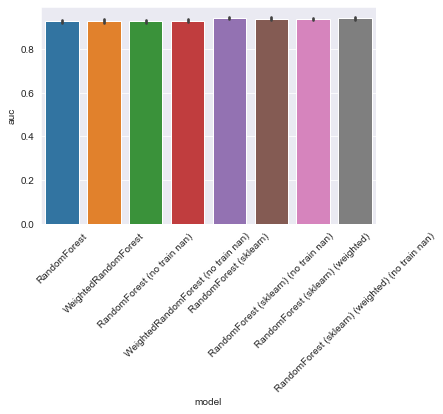

In [13]:
import seaborn as sns

baseline = scores[(scores['model'] == 'RandomForest')]['auc'].mean()
scores["improvement"] = scores["auc"] - baseline

plot = sns.barplot(x="model", y="auc", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

C:\Users\arnod\AppData\Local\Temp/ipykernel_36000/4067256330.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


[Text(0, -0.01, '0.91'),
 Text(0, -0.005, '0.92'),
 Text(0, 0.0, '0.92'),
 Text(0, 0.004999999999999999, '0.93'),
 Text(0, 0.01, '0.93'),
 Text(0, 0.015000000000000001, '0.94'),
 Text(0, 0.019999999999999997, '0.94'),
 Text(0, 0.025, '0.95')]

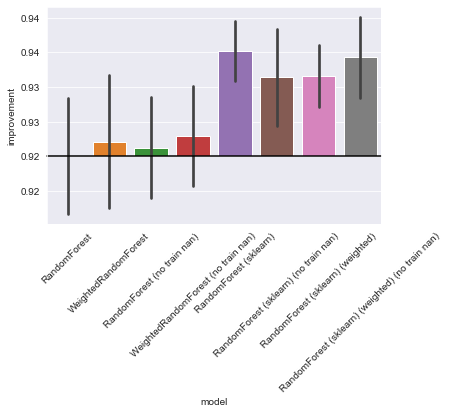

In [14]:

plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])

zien wat sklearn speciaal doet
zien of beter reageren op standaard datasets(van sklearn)-> om verschil te zien

# Other datasets
The sklearn implementation is better than our implementation. Let's see where the difference is.

In [1]:
from CustomForest import RandomForest
from sklearn.ensemble import RandomForestClassifier
# from sklearn.impute import SimpleImputer

models_to_evaluate = [
    {'name': 'RandomForest (sklearn)', 'model': RandomForestClassifier()},
    {'name': 'RandomForest', 'model': RandomForest()},
    # {'name': 'WeightedRandomForest', 'model': RandomForest(weighted=True)},
]

In [2]:
import pandas as pd
from util import evaluate_no_cv
from sklearn import metrics

def evaluate_models(models_to_evaluate, df, folds=5):
    scores = pd.DataFrame()

    for i, seed in enumerate(range(folds)):
        print(f'Fold {i + 1}/{folds}')

        for j, model in enumerate(models_to_evaluate):
            try:
                print(f"Running {model['name']} ({j + 1}/{len(models_to_evaluate)})")

                train, test = train_test_split(df, test_size=0.2, random_state=seed)
                x, y = train.drop(columns=['target']), train['target']
                x_test, y_test = test.drop(columns=['target']), test['target']

                clf = model['model']
                clf.fit(x, y)
                y_pred = clf.predict_proba(x_test)[:, 1]
                fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
                auc = metrics.auc(fpr, tpr)


                index = len(scores)
                scores.loc[index, 'model'] = model['name']
                scores.loc[index, 'auc'] = auc
            except Exception as e:
                print(f"Error: {e}")
                raise e
                continue

    return scores

In [5]:
%%time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from util import evaluate_cv_no_nan_test

dataset = load_breast_cancer()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']
# df = df.sample(100)

scores = evaluate_models(models_to_evaluate, df)

Fold 1/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [03:14<00:00,  1.95s/it]


Fold 2/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


Fold 3/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [03:11<00:00,  1.91s/it]


Fold 4/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


Fold 5/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [03:02<00:00,  1.82s/it]

Wall time: 16min 22s


In [6]:
scores

,model,auc
0,RandomForest (sklearn),0.996348
1,RandomForest,0.996189
2,RandomForest (sklearn),0.982639
3,RandomForest,0.982639
4,RandomForest (sklearn),0.981965
5,RandomForest,0.989050
6,RandomForest (sklearn),0.982095
7,RandomForest,0.987838
8,RandomForest (sklearn),0.991544
9,RandomForest,0.988051


[Text(0, 0, 'RandomForest (sklearn)'), Text(1, 0, 'RandomForest')]

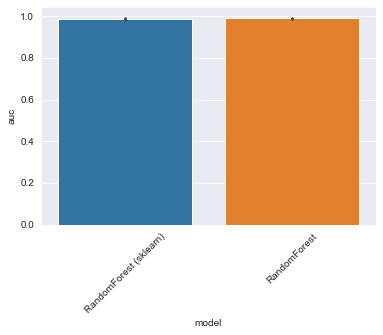

In [7]:
import seaborn as sns

baseline = scores[(scores['model'] == 'RandomForest')]['auc'].mean()
scores["improvement"] = scores["auc"] - baseline

plot = sns.barplot(x="model", y="auc", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

C:\Users\arnod\AppData\Local\Temp/ipykernel_21268/3746919118.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


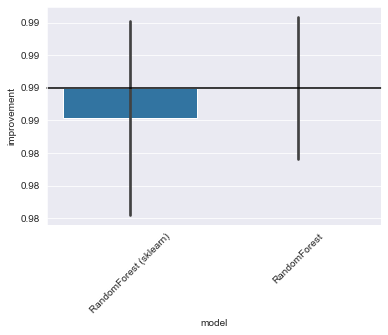

In [8]:
plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])
pass

performance is slightly better in sklearn, but it's almost the same. let's try a different dataset. breast_cancer is the only binary classification dataset in sklearn.  Let's [make our own](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html).

In [15]:
# %%time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from util import evaluate_cv_no_nan_test

dataset = make_classification(n_samples=100,n_features=20,n_classes=2)
df = pd.DataFrame(dataset[0])
df['target'] = dataset[1]

scores = evaluate_models(models_to_evaluate, df)

Fold 1/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


Fold 2/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


Fold 3/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


Fold 4/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


Fold 5/5
Running RandomForest (sklearn) (1/2)
Running RandomForest (2/2)


100%|██████████| 100/100 [00:08<00:00, 11.24it/s]


In [16]:
scores

,model,auc
0,RandomForest (sklearn),1.000000
1,RandomForest,1.000000
2,RandomForest (sklearn),0.994792
3,RandomForest,1.000000
4,RandomForest (sklearn),1.000000
5,RandomForest,1.000000
6,RandomForest (sklearn),0.989899
7,RandomForest,0.919192
8,RandomForest (sklearn),0.978022
9,RandomForest,0.945055


[Text(0, 0, 'RandomForest (sklearn)'), Text(1, 0, 'RandomForest')]

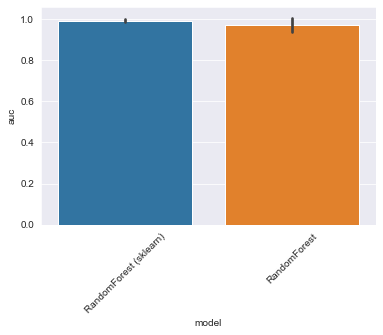

In [17]:
import seaborn as sns

baseline = scores[(scores['model'] == 'RandomForest')]['auc'].mean()
scores["improvement"] = scores["auc"] - baseline

plot = sns.barplot(x="model", y="auc", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)

C:\Users\arnod\AppData\Local\Temp/ipykernel_21268/3746919118.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])


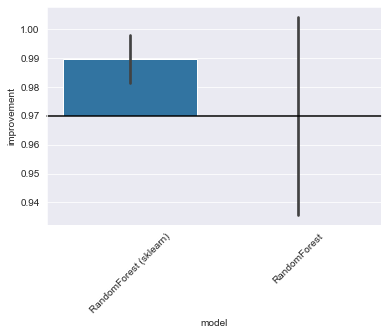

In [18]:
plot = sns.barplot(x="model", y="improvement", data=scores, ci="sd")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.axhline(0, color="k", clip_on=False)
y_ticks = plot.get_yticks()
plot.set_yticklabels([f"{baseline + y:.2f}" for y in y_ticks])
pass

I attempted taking a look at the sklearn code to modify it (and to see which algorithm is actually implemented), but it's indeed written partly in C. The classes I needed to edit where either the DepthFirstTreeBuilder or a Splitter. However,those functions are written in python as a pass, which is probably because PyCharm only shows me  the interface:
https://stackoverflow.com/questions/38384206/why-do-some-built-in-python-functions-only-have-pass.

I found their implementation type online: https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart

What are all the various decision tree algorithms and how do they differ from each other? Which one is implemented in scikit-learn?

ID3 (Iterative Dichotomiser 3) was developed in 1986 by Ross Quinlan. The algorithm creates a multiway tree, finding for each node (i.e. in a greedy manner) the categorical feature that will yield the largest information gain for categorical targets. Trees are grown to their maximum size and then a pruning step is usually applied to improve the ability of the tree to generalize to unseen data.

C4.5 is the successor to ID3 and removed the restriction that features must be categorical by dynamically defining a discrete attribute (based on numerical variables) that partitions the continuous attribute value into a discrete set of intervals. C4.5 converts the trained trees (i.e. the output of the ID3 algorithm) into sets of if-then rules. The accuracy of each rule is then evaluated to determine the order in which they should be applied. Pruning is done by removing a rule’s precondition if the accuracy of the rule improves without it.

C5.0 is Quinlan’s latest version release under a proprietary license. It uses less memory and builds smaller rulesets than C4.5 while being more accurate.

CART (Classification and Regression Trees) is very similar to C4.5, but it differs in that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees using the feature and threshold that yield the largest information gain at each node.

scikit-learn uses an optimized version of the CART algorithm; however, the scikit-learn implementation does not support categorical variables for now.





Chefboost seems to be entirely written in python (accoording to it's [github repo](https://github.com/serengil/chefboost). However,it's also notwhat I want, read [this](https://towardsdatascience.com/chefboost-an-alternative-python-library-for-tree-based-models-f46af028a348) for more about chefboost/sklearn comparison.

[This reddit post](https://www.reddit.com/r/MachineLearning/comments/aryjif/d_alternatives_to_scikitlearn/) asks for sklearn alternatives. statsmodel is mentioned there, but it  doesn't seem to have a decision tree implementation.

I was thinking on using an implementation from a [tutorial](https://machinelearningmastery.com/implement-random-forest-scratch-python/), but doubt it will be faster, since it doesn't even use numpy.

I might check out [this implementation](https://github.com/sachaMorin/np-random-forest).

In [13]:
from NpRandomForest import Forest
from util import get_train_dataset, get_features, fix_test
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

df = get_train_dataset()
# df =df.sample(100)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_test.dropna(inplace=True)

train_features = get_features(df_train)
val_features = get_features(df_test, test=True)
val_features = fix_test(val_features, train_features.columns)
train_label = df_train['reaction']
val_label = df_test['reaction']

imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
# train_features = pd.DataFrame(imp.fit_transform(train_features), columns=train_features.columns)
train_features = imp.fit_transform(train_features)

In [14]:
train_label = train_label.to_numpy()
val_features = val_features.to_numpy()
val_label = val_label.to_numpy()

In [15]:
# samples
print(f"The train dataset has {train_features.shape[0]} samples and {train_features.shape[1]} features")
print(f"The test dataset has {val_features.shape[0]} samples and {val_features.shape[1]} features")

The train dataset has 6645 samples and 1194 features
The test dataset has 666 samples and 1194 features


In [16]:
%%time
# code based on main function of NpRandomForest
# Number of features searched by split. Use square root as default.
total_features = train_features.shape[1]
feature_search = int(np.sqrt(total_features))
bootstrap = True # first testing without, since it doesn't work
max_depth = 8 # since it's their default max depth, sklearn has no max depth and keeps splittin until pure, so maybe change this to 100
no_trees = 100

print(f"Training {no_trees} trees with {feature_search} features per split (of the {total_features} total features) and max depth {max_depth}")

# no_trees = 2 # debugging

forest = Forest(max_depth=max_depth, no_trees=no_trees,
                min_samples_split=2, min_samples_leaf=1,
                feature_search=feature_search, bootstrap=bootstrap)

forest.train(train_features, train_label)

Training 100 trees with 34 features per split (of the 1194 total features) and max depth 8


Training Forest Trees:   0%|          | 0/100 [08:33<?, ?it/s]


MemoryError: Unable to allocate 60.5 MiB for an array with shape (6645, 1194) and data type float64

In [17]:
assert train_features.shape[1] == val_features.shape[1]
train_accuracy = forest.eval(train_features, train_label)
test_accuracy = forest.eval(val_features, val_label)
node_count = forest.node_count()
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")
print(f"Node count: {node_count}")
print(f"Train samples: {train_features.shape[0]}")
print(f"Test samples: {val_features.shape[0]}")

ValueError: attempt to get argmax of an empty sequence

MemoryError, this implementation is probably not suitable for datasets of this size. [This stackexchange post](https://stats.stackexchange.com/questions/26510/how-to-implement-a-customized-random-forest-classifier) suggests editting the sklearn code.